# Imports

In [1]:
# imports
import sys
sys.path.append('..')
from functions import *
from geometry import *
from networks import *
from plotting import *
from transforms import *
from tqdm import tqdm

In [2]:
import os
# Change to the directory where the train folder is located
os.chdir('../writeup_notebooks_sup')
# Verify the change
print("New Working Directory:", os.getcwd())

New Working Directory: /Users/giuliofilippi/Documents/Code/fpm-paper/writeup_notebooks_sup


In [3]:
# import matplotlib
import matplotlib.pyplot as plt

# format sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

# matplotlib params
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['xtick.direction'] = 'out' # ticks points outwards
plt.rcParams['lines.linewidth'] = 2.0 # bigger linewidth
plt.rcParams['svg.fonttype'] = 'none' # matplotlib svg text setting

# Base Shape

In [4]:
train_path = np.load('../paths/train/path_1a.npy')
train_path_down = [downsample_and_flatten_transform(arr) for arr in train_path]
train_image = train_path[0]
FPM = compute_fpm(train_image)
FPM

0.1875

<Axes: title={'center': 'Image'}, xlabel='X-axis', ylabel='Y-axis'>

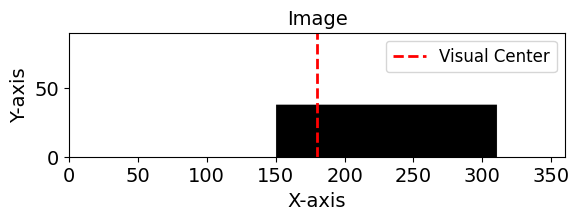

In [5]:
plot_image(train_image)

# Create Test Shapes

In [6]:
# rectangle width 120
test_vertices_1 = np.array([[0,0],[180-40,0],[180-40,38],[180+80,38],[180+80,0],[360,0]])
test_shape_1 = draw_image(test_vertices_1)

# rectangle width 80
test_vertices_2 = np.array([[0,0],[180-40,0],[180-40,38],[180+40,38],[180+40,0],[360,0]])
test_shape_2 = draw_image(test_vertices_2)

# rectangle width 40
test_vertices_3 = np.array([[0,0],[180-40,0],[180-40,38],[180+0,38],[180+0,0],[360,0]])
test_shape_3 = draw_image(test_vertices_3)

In [7]:
# FPM location 1
x_fpm_1 = x_from_fpm(image=test_shape_1, fpm=FPM)
theoretical_angle_1 =  x_fpm_1 - 180

# FPM location 2
x_fpm_2 = x_from_fpm(image=test_shape_2, fpm=FPM)
theoretical_angle_2 =  x_fpm_2 - 180

# FPM location 3
x_fpm_3 = x_from_fpm(image=test_shape_3, fpm=FPM)
theoretical_angle_3 =  x_fpm_3 - 180

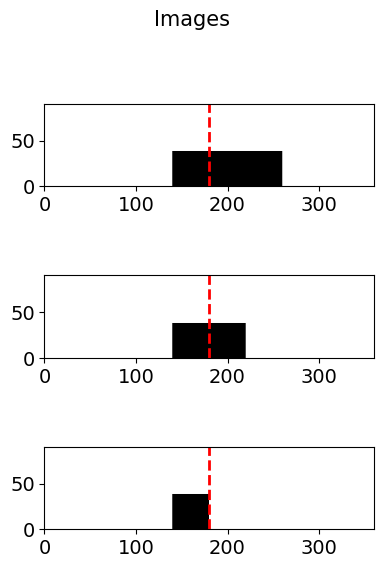

In [8]:
plot_images([test_shape_1, test_shape_2, test_shape_3])

# Initialize alpha Colonies

In [9]:
# params
n_vpn = 20 * 90
n_kc = 25000
k = 8
p = 0.05
q_l = None # only useful if initialising weights
q_r = None # only useful if initialising weights
alpha = 0.95
mode="top"
init_weights=False
weight_mode='1'
training_mode='exp'
epsilon=0

In [10]:
# dict of colonies
colony_names = [0.99, 0.95, 0.9]
colony_size = 50
colony_dict = {name:[] for name in colony_names}

for col in colony_names:
    alpha = col
    for i in range(colony_size):
        # initialize
        model = LRMBNetwork(
                        n_vpn, 
                        n_kc, 
                        k, 
                        p, 
                        q_l, 
                        q_r, 
                        alpha, 
                        mode, 
                        init_weights, 
                        weight_mode, 
                        training_mode,
                        epsilon)
        # load weights
        model.LeftMB.load_weights('../params_fwd/DS/ant_{}_L.pth'.format(i))
        model.RightMB.load_weights('../params_fwd/DS/ant_{}_R.pth'.format(i))
        # append to colony
        colony_dict[alpha].append(model)

In [11]:
# train all colonies on the train image
for name, colony in colony_dict.items():
    print (name)
    for model in colony:
        model.LeftMB.initialize_output_weights()
        model.RightMB.initialize_output_weights()
        model.train_network(train_path_down)

0.99


/Users/giuliofilippi/Documents/Code/fpm-paper/writeup_notebooks_sup/../networks.py:270: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  image_sequence = torch.Tensor(image_sequence).unsqueeze(1)


0.95
0.9


## Results for Shape 1

<Axes: title={'center': 'Image'}, xlabel='X-axis', ylabel='Y-axis'>

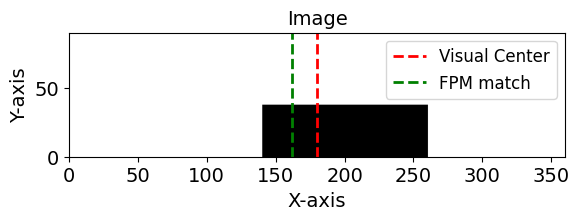

In [12]:
test_image = test_shape_1
x_fpm = x_fpm_1
theoretical_angle = theoretical_angle_1
plot_image(test_image, fpm=x_fpm)

In [13]:
# initialize results dictionnaries
left_dict = {}
right_dict = {}
sum_dict = {}
diff_dict = {}

In [14]:
# get test rotations
test_rotations = get_rotations(test_image)
test_rotations_transformed = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_transformed]
rotation_tensor = torch.stack(rotation_tensor)

# loop over colonies ()params
for col in tqdm(colony_names):
    # print colony name
    print (col)

    # initialise arrays
    left_arr = np.zeros((colony_size, 360))
    right_arr = np.zeros((colony_size, 360))
    sum_arr = np.zeros((colony_size, 360))
    diff_arr = np.zeros((colony_size, 360))

    # run all models and get matrices
    for i in range(colony_size):
        model = colony_dict[col][i]
        l, r, s, d = model.forward(rotation_tensor)
        left_arr[i,:] = l.detach().numpy().flatten()
        right_arr[i,:] = r.detach().numpy().flatten()
        sum_arr[i,:] = s.detach().numpy().flatten()
        diff_arr[i,:] = d.detach().numpy().flatten()

    # set the dictionnary to the appropriate matrix
    left_dict[col] = left_arr
    right_dict[col] = right_arr
    sum_dict[col] = sum_arr
    diff_dict[col] = diff_arr

  0%|          | 0/3 [00:00<?, ?it/s]

0.99


 33%|███▎      | 1/3 [00:09<00:19,  9.76s/it]

0.95


 67%|██████▋   | 2/3 [00:19<00:09,  9.74s/it]

0.9


100%|██████████| 3/3 [00:29<00:00,  9.81s/it]


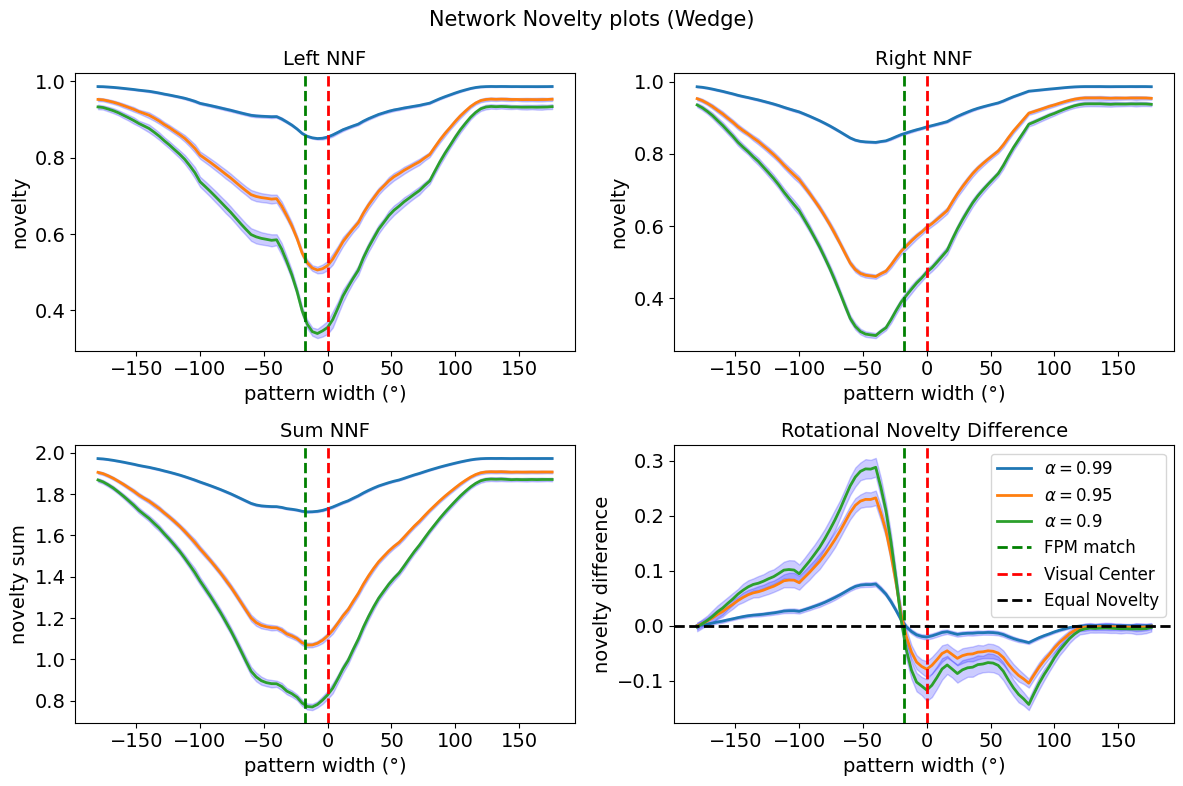

In [15]:
# Signal dictionnaries
signals = [left_dict, right_dict, sum_dict, diff_dict]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

plt.suptitle('Network Novelty plots (Wedge)')

# Plot on each subplot
for i, ax in enumerate(axs.flat):
    # angles
    angles = range(-180, 180, 1)

    # Plot the mean curves
    for col in colony_names:
        mean_curve = np.mean(signals[i][col], axis=0)
        std_curve = np.std(signals[i][col], axis=0)
        ax.plot(angles[::4], np.roll(mean_curve, shift=180)[::4], label=r'$\alpha=$'+str(col))
        ax.fill_between(angles[::4], np.roll(mean_curve - std_curve, shift=180)[::4], np.roll(mean_curve + std_curve, shift=180)[::4], color='blue',alpha=0.2)
    
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel('pattern width (°)')
    ax.set_title(titles[i])
    ax.axvline(x=theoretical_angle, color='green', linestyle='--', label='FPM match')
    ax.axvline(x=0, color='red', linestyle='--', label='Visual Center')
    if i == 3:
        ax.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
        ax.legend(loc='upper right')  # Add legend to each subplot

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

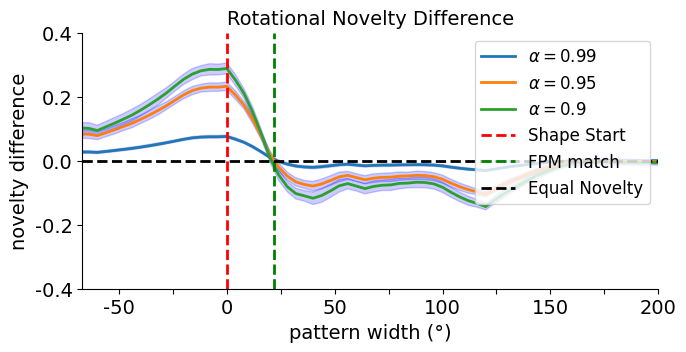

In [16]:
# Signal dictionnaries
signals = [left_dict, right_dict, sum_dict, diff_dict]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 40
i = 3

# angles
angles = np.array(range(-180, 180, 1))+ROLL

# Plot the mean curves
for col in colony_names:
    mean_curve = np.mean(signals[i][col], axis=0)
    std_curve = np.std(signals[i][col], axis=0)
    # Plot the mean curve
    plt.plot(angles[::4], np.roll(mean_curve, shift=180)[::4], label=r'$\alpha=$'+str(col))
    plt.fill_between(angles[::4], np.roll(mean_curve - std_curve, shift=180)[::4], np.roll(mean_curve + std_curve, shift=180)[::4], color='blue',alpha=0.2)

# Labelling
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.ylim(-0.4, 0.4) # ylim # ylim
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_sup/a/diff_shape_1.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

## Results for Shape 2

<Axes: title={'center': 'Image'}, xlabel='X-axis', ylabel='Y-axis'>

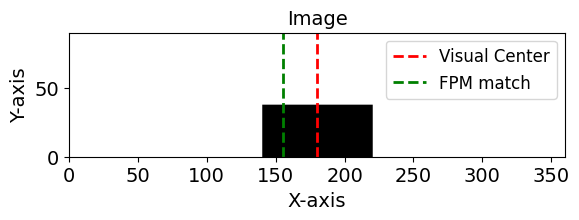

In [17]:
test_image = test_shape_2
x_fpm = x_fpm_2
theoretical_angle = theoretical_angle_2
plot_image(test_image, fpm=x_fpm)

In [18]:
# initialize results dictionnaries
left_dict = {}
right_dict = {}
sum_dict = {}
diff_dict = {}

In [19]:
# get test rotations
test_rotations = get_rotations(test_image)
test_rotations_transformed = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_transformed]
rotation_tensor = torch.stack(rotation_tensor)

# loop over colonies ()params
for col in tqdm(colony_names):
    # print colony name
    print (col)

    # initialise arrays
    left_arr = np.zeros((colony_size, 360))
    right_arr = np.zeros((colony_size, 360))
    sum_arr = np.zeros((colony_size, 360))
    diff_arr = np.zeros((colony_size, 360))

    # run all models and get matrices
    for i in range(colony_size):
        model = colony_dict[col][i]
        l, r, s, d = model.forward(rotation_tensor)
        left_arr[i,:] = l.detach().numpy().flatten()
        right_arr[i,:] = r.detach().numpy().flatten()
        sum_arr[i,:] = s.detach().numpy().flatten()
        diff_arr[i,:] = d.detach().numpy().flatten()

    # set the dictionnary to the appropriate matrix
    left_dict[col] = left_arr
    right_dict[col] = right_arr
    sum_dict[col] = sum_arr
    diff_dict[col] = diff_arr

  0%|          | 0/3 [00:00<?, ?it/s]

0.99


 33%|███▎      | 1/3 [00:11<00:22, 11.16s/it]

0.95


 67%|██████▋   | 2/3 [00:22<00:11, 11.01s/it]

0.9


100%|██████████| 3/3 [00:32<00:00, 10.82s/it]


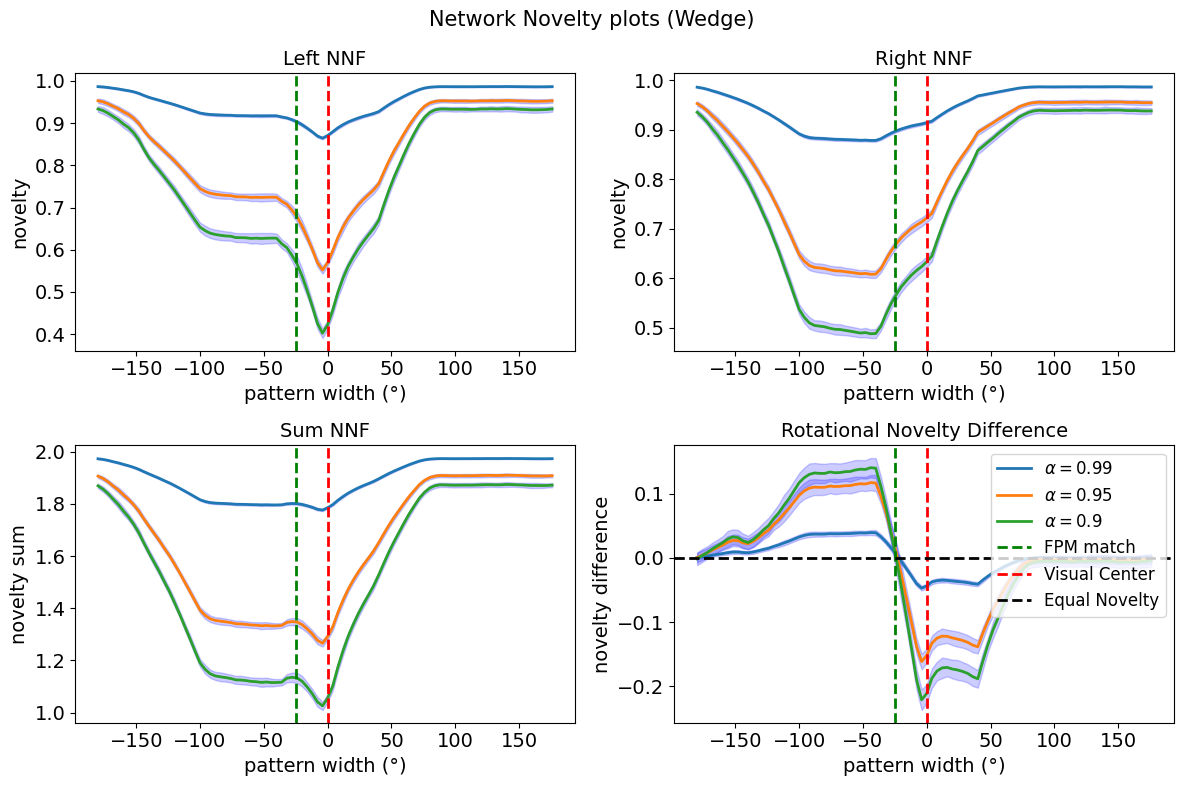

In [20]:
# Signal dictionnaries
signals = [left_dict, right_dict, sum_dict, diff_dict]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

plt.suptitle('Network Novelty plots (Wedge)')

# Plot on each subplot
for i, ax in enumerate(axs.flat):
    # angles
    angles = range(-180, 180, 1)

    # Plot the mean curves
    for col in colony_names:
        mean_curve = np.mean(signals[i][col], axis=0)
        std_curve = np.std(signals[i][col], axis=0)
        ax.plot(angles[::4], np.roll(mean_curve, shift=180)[::4], label=r'$\alpha=$'+str(col))
        ax.fill_between(angles[::4], np.roll(mean_curve - std_curve, shift=180)[::4], np.roll(mean_curve + std_curve, shift=180)[::4], color='blue',alpha=0.2)
    
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel('pattern width (°)')
    ax.set_title(titles[i])
    ax.axvline(x=theoretical_angle, color='green', linestyle='--', label='FPM match')
    ax.axvline(x=0, color='red', linestyle='--', label='Visual Center')
    if i == 3:
        ax.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
        ax.legend(loc='upper right')  # Add legend to each subplot

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

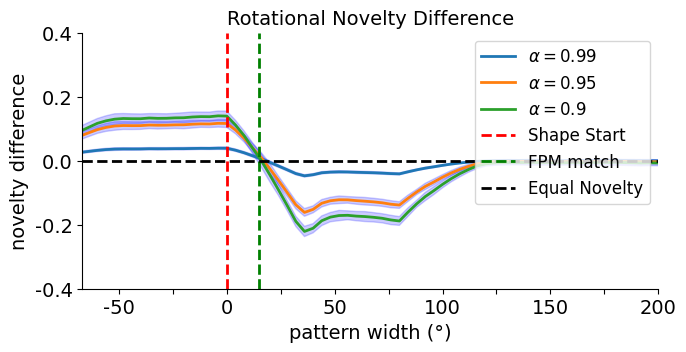

In [21]:
# Signal dictionnaries
signals = [left_dict, right_dict, sum_dict, diff_dict]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 40
i = 3

# angles
angles = np.array(range(-180, 180, 1))+ROLL

# Plot the mean curves
for col in colony_names:
    mean_curve = np.mean(signals[i][col], axis=0)
    std_curve = np.std(signals[i][col], axis=0)
    # Plot the mean curve
    plt.plot(angles[::4], np.roll(mean_curve, shift=180)[::4], label=r'$\alpha=$'+str(col))
    plt.fill_between(angles[::4], np.roll(mean_curve - std_curve, shift=180)[::4], np.roll(mean_curve + std_curve, shift=180)[::4], color='blue',alpha=0.2)

# Labelling
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.ylim(-0.4, 0.4) # ylim
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_sup/a/diff_shape_2.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

## Results for Shape 3

<Axes: title={'center': 'Image'}, xlabel='X-axis', ylabel='Y-axis'>

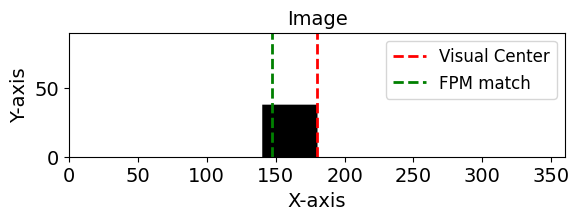

In [22]:
test_image = test_shape_3
x_fpm = x_fpm_3
theoretical_angle = theoretical_angle_3
plot_image(test_image, fpm=x_fpm)

In [23]:
# initialize results dictionnaries
left_dict = {}
right_dict = {}
sum_dict = {}
diff_dict = {}

In [24]:
# get test rotations
test_rotations = get_rotations(test_image)
test_rotations_transformed = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_transformed]
rotation_tensor = torch.stack(rotation_tensor)

# loop over colonies ()params
for col in tqdm(colony_names):
    # print colony name
    print (col)

    # initialise arrays
    left_arr = np.zeros((colony_size, 360))
    right_arr = np.zeros((colony_size, 360))
    sum_arr = np.zeros((colony_size, 360))
    diff_arr = np.zeros((colony_size, 360))

    # run all models and get matrices
    for i in range(colony_size):
        model = colony_dict[col][i]
        l, r, s, d = model.forward(rotation_tensor)
        left_arr[i,:] = l.detach().numpy().flatten()
        right_arr[i,:] = r.detach().numpy().flatten()
        sum_arr[i,:] = s.detach().numpy().flatten()
        diff_arr[i,:] = d.detach().numpy().flatten()

    # set the dictionnary to the appropriate matrix
    left_dict[col] = left_arr
    right_dict[col] = right_arr
    sum_dict[col] = sum_arr
    diff_dict[col] = diff_arr

  0%|          | 0/3 [00:00<?, ?it/s]

0.99


 33%|███▎      | 1/3 [00:11<00:22, 11.21s/it]

0.95


 67%|██████▋   | 2/3 [00:21<00:10, 10.79s/it]

0.9


100%|██████████| 3/3 [00:33<00:00, 11.24s/it]


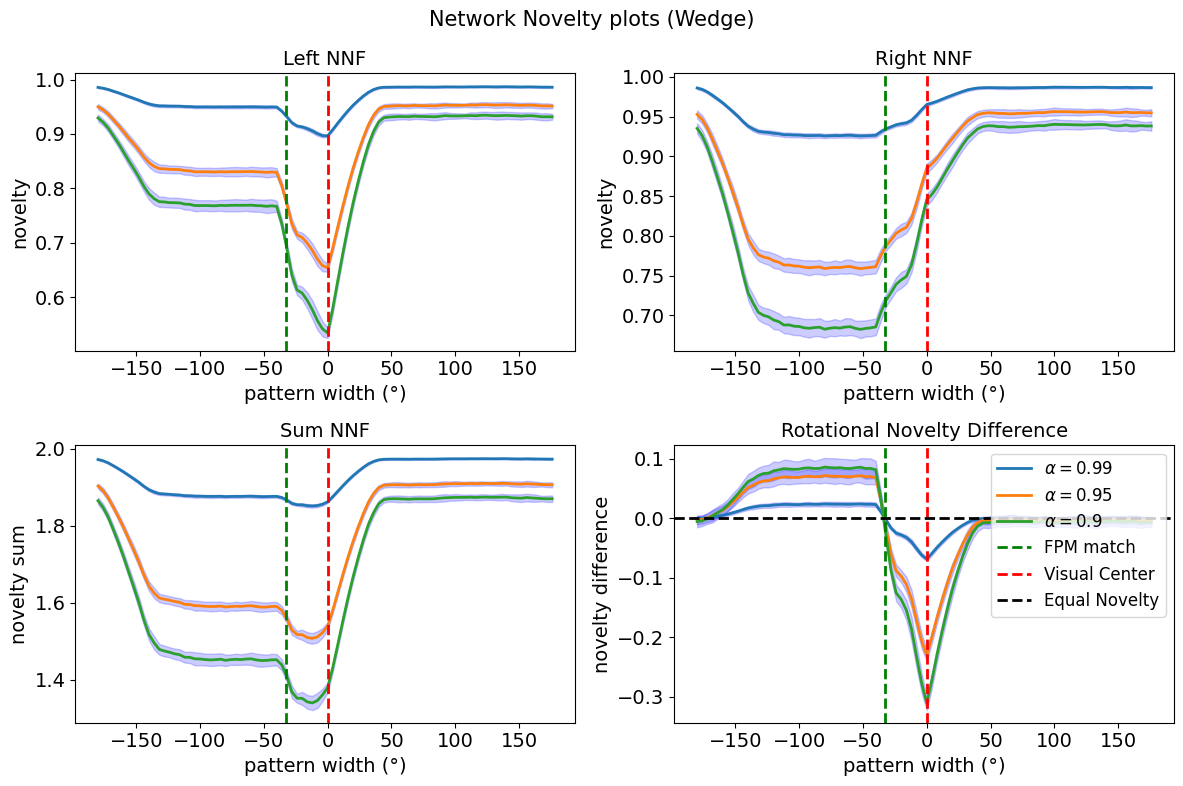

In [25]:
# Signal dictionnaries
signals = [left_dict, right_dict, sum_dict, diff_dict]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

plt.suptitle('Network Novelty plots (Wedge)')

# Plot on each subplot
for i, ax in enumerate(axs.flat):
    # angles
    angles = range(-180, 180, 1)

    # Plot the mean curves
    for col in colony_names:
        mean_curve = np.mean(signals[i][col], axis=0)
        std_curve = np.std(signals[i][col], axis=0)
        ax.plot(angles[::4], np.roll(mean_curve, shift=180)[::4], label=r'$\alpha=$'+str(col))
        ax.fill_between(angles[::4], np.roll(mean_curve - std_curve, shift=180)[::4], np.roll(mean_curve + std_curve, shift=180)[::4], color='blue',alpha=0.2)
    
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel('pattern width (°)')
    ax.set_title(titles[i])
    ax.axvline(x=theoretical_angle, color='green', linestyle='--', label='FPM match')
    ax.axvline(x=0, color='red', linestyle='--', label='Visual Center')
    if i == 3:
        ax.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
        ax.legend(loc='upper right')  # Add legend to each subplot

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

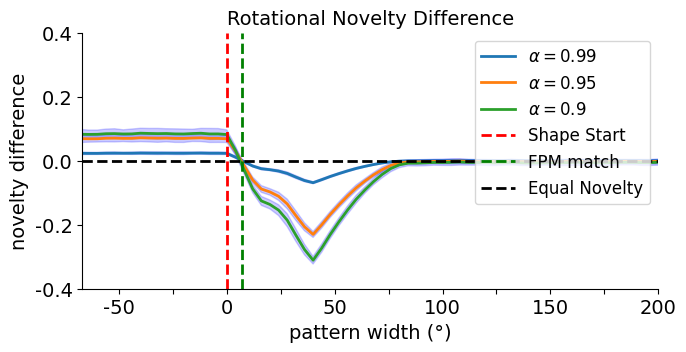

In [26]:
# Signal dictionnaries
signals = [left_dict, right_dict, sum_dict, diff_dict]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 40
i = 3

# angles
angles = np.array(range(-180, 180, 1))+ROLL

# Plot the mean curves
for col in colony_names:
    mean_curve = np.mean(signals[i][col], axis=0)
    std_curve = np.std(signals[i][col], axis=0)
    # Plot the mean curve
    plt.plot(angles[::4], np.roll(mean_curve, shift=180)[::4], label=r'$\alpha=$'+str(col))
    plt.fill_between(angles[::4], np.roll(mean_curve - std_curve, shift=180)[::4], np.roll(mean_curve + std_curve, shift=180)[::4], color='blue',alpha=0.2)

# Labelling
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.ylim(-0.4, 0.4) # ylim
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_sup/a/diff_shape_3.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()